In [1]:
using LowRankApprox
using LinearAlgebra
using Jacobi
using Test

# AC quad element with added more supplements basis 

In [2]:
function BilinearMap(coord_E, xhat, yhat)
    """ 
    This function maps [xhat,yhat] in Ehat=[-1,1]^2 
    to (x,y) in E.
    Written based on eq. (3.3), (3.4) of AC paper 2016
    Input:
    ------
    coord_E: coordinates of quadrilateral E .
    coord_E is 4x2 array
    coord_E = [[x1,y1],
               [x2,y2],
               [x3,y3],
               [x4,y4]] with vertices numbering
    3----4
    |    |
    1----2
    [xhat, yhat] in Ehat
    Output:
    ------
    [x;y]: mapped vector in E.
    DF_E: Jacobian matrix
    J_E: det(DF_E)
    later we transform vector vhat to v by eq. (3.4)
    v(x) = P_E(vhat)(x) = (DF_E/J_E)*vhat(xhat)
    """
    m = length(xhat)
    P = 0.25 * [(1 .- xhat).*(1 .- yhat) (1 .+ xhat).*(1 .- yhat) (1 .- xhat).*(1 .+ yhat) (1 .+ xhat).*(1 .+ yhat)]
    P_E = P * coord_E
    # x=F_E(xhat)
    X = P_E
    x = X[:, 1]
    y = X[:, 2]
    # gradient of P, 1st row = dP/dxhat, 2nd row=dP/dyhat
    # GradP_(2m x 4)
    GradP = 0.25 * [-(1 .- yhat) (1 .- yhat) -(1 .+ yhat) (1 .+ yhat);
                    -(1 .- xhat) -(1 .+ xhat) (1 .- xhat) (1 .+ xhat)]

    # JT= [[dx/dxhat, dy/dxhat],
    #      [dx/dyhat, dy/dyhat]] (2m x 2)
    JT = GradP * coord_E
    dxdxhat = JT[1:m,1]
    dydxhat = JT[1:m,2]
    dxdyhat = JT[m+1:2*m,1]
    dydyhat = JT[m+1:2*m,2]
    J_E = @. dxdxhat * dydyhat - dydxhat * dxdyhat
    
    DF_E = [dxdxhat dxdyhat;dydxhat dydyhat]
    
    return x, y, DF_E, J_E
end

BilinearMap (generic function with 1 method)

In [3]:
function PrimeBasis(coord_E, xhat, yhat)

    # original supplements in AC paper
    sghat1 = [(1 .- xhat.^2) (2*xhat .* yhat)]
    sghat2 = [(-2*xhat .* yhat) (yhat.^2 .- 1)]
    # New redundant supplements
    sghat3 = [(2*yhat .* (1 .+ xhat .+ xhat.^3)) -((1 .+ 3*xhat.^2).* yhat.^2)]
    sghat4 = [((1 .+ 3*yhat.^2).* xhat.^2) -(2*xhat .* (1 .+ yhat .+ yhat.^3))]
    
    # (x,y) are in E
    x, y, DF_E, J_E = BilinearMap(coord_E, xhat, yhat)

    m = length(xhat)
    # we have 10 basis in 2D space
    P1 = zeros(2,m,10)
    P1[1,:,1] = ones(m)
    P1[1,:,2] = x
    P1[1,:,3] = y
    P1[2,:,4] = ones(m)
    P1[2,:,5] = x
    P1[2,:,6] = y
    # supplement
    P1[1,:,7] = (DF_E[1:m,1] .* sghat1[:,1] + DF_E[1:m,2] .* sghat1[:,2]) ./ J_E
    P1[2,:,7] = (DF_E[m+1:2*m,1] .* sghat1[:,1] + DF_E[m+1:2*m,2] .* sghat1[:,2]) ./ J_E
    
    P1[1,:,8] = (DF_E[1:m,1] .* sghat3[:,1] + DF_E[1:m,2] .* sghat3[:,2]) ./ J_E
    P1[2,:,8] = (DF_E[m+1:2*m,1] .* sghat3[:,1] + DF_E[m+1:2*m,2] .* sghat3[:,2]) ./ J_E
    # Redundant supplement
    P1[1,:,9] = (DF_E[1:m,1] .* sghat2[:,1] + DF_E[1:m,2] .* sghat2[:,2]) ./ J_E
    P1[2,:,9] = (DF_E[m+1:2*m,1] .* sghat2[:,1] + DF_E[m+1:2*m,2] .* sghat2[:,2]) ./ J_E
    
    P1[1,:,10] = (DF_E[1:m,1] .* sghat4[:,1] + DF_E[1:m,2] .* sghat4[:,2]) ./ J_E
    P1[2,:,10] = (DF_E[m+1:2*m,1] .* sghat4[:,1] + DF_E[m+1:2*m,2] .* sghat4[:,2]) ./ J_E
    
    P = zeros(2*m,10)    
    P[1:m,:] = P1[1,:,:]
    P[m+1:2*m,:] = P1[2,:,:]
    
    return P
end

PrimeBasis (generic function with 1 method)

In [4]:
function GetNormal(coord_E, xhat, yhat, edge)

    m = length(xhat)
    if edge == "left"
        # left edge, (0,0,1)x(dxdyhat,dydyhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, xhat, yhat)
        dxdyhat = DF_E[1:m,2]
        dydyhat = DF_E[m+1:2*m,2]
        length2 = @. sqrt(dxdyhat*dxdyhat + dydyhat*dydyhat)
        n = [-dydyhat ./ length2; dxdyhat ./ length2] 

    elseif edge == "right"
        # right edge, (0,0,-1)x(dxdyhat,dydyhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, xhat, yhat)
        dxdyhat = DF_E[1:m,2]
        dydyhat = DF_E[m+1:2*m,2]
        length2 = @. sqrt(dxdyhat*dxdyhat + dydyhat*dydyhat)
        n = [dydyhat ./ length2; -dxdyhat ./ length2]

    elseif edge == "bottom"
        # bottom edge, (0,0,-1)x(dxdxhat,dydxhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, xhat, yhat)
        dxdxhat = DF_E[1:m,1]
        dydxhat = DF_E[m+1:2*m,1]
        length1 = @. sqrt(dxdxhat*dxdxhat + dydxhat*dydxhat)
        n = [dydxhat ./ length1; -dxdxhat ./ length1]

    elseif edge == "top"
        # top edge, (0,0,1)x(dxdxhat,dydxhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, xhat, yhat)
        dxdxhat = DF_E[1:m,1]
        dydxhat = DF_E[m+1:2*m,1]
        length1 = @. sqrt(dxdxhat*dxdxhat + dydxhat*dydxhat)
        n = [-dydxhat ./ length1; dxdxhat ./ length1]

    else
        println("Error! Enter the Xhat=[xhat, yhat] on the edge of Ehat")
    
    end

    return n
end

GetNormal (generic function with 1 method)

In [5]:
function ConstraintMat(coord_E)
    """
    Input:
    ------
    coord_E: is the coordinate of vertices of element.
    Note
    3---4
    |   |
    1---2
    
    mode: QR or SVD
    Output:
    ------
    VM: the 8x8 vondermonde matrix
    """
    
    # Gauss Quadrature
    Q = 3
    alpha=0.0
    beta = 0.0
    q = zgj(Q, alpha, beta)
    w = wgj(q, alpha, beta)
    nm = -ones(Q)
    np = ones(Q)
    # normals on edges
    nl = GetNormal(coord_E, nm, q, "left")
    nr = GetNormal(coord_E, np, q, "right")
    nb = GetNormal(coord_E, q, nm, "bottom")
    nt = GetNormal(coord_E, q, np, "top")
    
    normals = [nb nt nr nl]
    # these are (xhat,yhat) for each edge
    nodes = [q nm q np np q nm q]
    # Constraint matrix
    L = zeros(4,10)
    for i=1:4 # loop over edges
        for j=1:10 # loop over dim(P)
            P = PrimeBasis(coord_E, nodes[:,2*i-1], nodes[:,2*i])
            PdotN = P[1:Q,j] .* normals[1:Q,i] + P[Q+1:2*Q,j] .* normals[Q+1:2*Q,i]
            leg = legendre.(q, 2)
            leg_w = leg .* w
            # loop over quadrature
            L[i,j] = dot(PdotN, leg_w)
        end
    end
    
    return L
end

ConstraintMat (generic function with 1 method)

In [6]:
function GetNullL(L)
    F=pqrfact(L')
    Qfull, _ = qr(F[:Q])
    VL = Qfull[:, 3:end]
    return VL
end

GetNullL (generic function with 1 method)

In [7]:
function clip(x; threshold=1e-12)
    y = copy(x)
    y[abs.(y) .< threshold] .= 0
    y
end

clip (generic function with 1 method)

In [8]:
function GetACNodalBasis(coord_E, xhat, yhat, VL)
    """This function returns the AC Nodal basis at point Xhat=[xhat,yhat]
    Input:
    ------
    coord_E: coordinate of element E as 4x2 array
    (xhat,yhat): is the coordinate at reference element [-1,1]^2
    VL: computed in GetNullL(L) function
    
    Output:
    -------
    Nhat: the nodal basis computed at (xhat,yhat)
    Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    local numbering is as follow 
     v7     v8
    3---------4
  v6|         |v4
    |         |
  v5|         |v3
    1---------2
     v1     v2
    """
    nl = GetNormal(coord_E, [-1], [0], "left")
    nr = GetNormal(coord_E, [1], [0],  "right")
    nb = GetNormal(coord_E, [0], [-1], "bottom")
    nt = GetNormal(coord_E, [0],[1],  "top")
    normals = [nb nb nr nr nl nl nt nt]
    node1 = [-1.;-1.]
    node2 = [1.;-1.]
    node3 = [-1.;1.]
    node4 = [1.;1.]
    nodes = [node1 node2 node2 node4 node1 node3 node3 node4]
    
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(8,8)
    for i=1:8
        for j=1:8
            # original prime basis with dim=10
            P = PrimeBasis(coord_E, [nodes[1,i]], [nodes[2,i]])
            # reduced prime basis with dim=8
            PP = P * VL
            VM[i,j] = dot(PP[:,j],normals[:,i])
        end
    end
    
    # create nodal basis from vondermonde (VM) and VL
    P = PrimeBasis(coord_E, xhat, yhat)
    invVM = inv(VM)
    # nodal basis function
    Nhat = P * VL * invVM

    return Nhat
end

GetACNodalBasis (generic function with 1 method)

In [9]:
@testset "TestNodalBasisUniform" begin

    coord_E = [0. 0.;.5 0.;0. .5;.5 .5]
    L = ConstraintMat(coord_E)
    VL = GetNullL(L)
    nl = GetNormal(coord_E, [-1], [0], "left")
    nr = GetNormal(coord_E, [1], [0],  "right")
    nb = GetNormal(coord_E, [0], [-1], "bottom")
    nt = GetNormal(coord_E, [0],[1],  "top")
    
    err = 1e-14
    
    # check node 1
    Nhat = GetACNodalBasis(coord_E,[-1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v1.nb=1 and v5.nl=1
    @test isapprox(dot(Nhat[:,1],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 2
    Nhat = GetACNodalBasis(coord_E,[1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v2.nb=1 and v3.nr=1
    @test isapprox(dot(Nhat[:,2],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 3
    Nhat = GetACNodalBasis(coord_E,[-1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v6.nl=1 and v7.nt=1
    @test isapprox(dot(Nhat[:,6],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 4
    Nhat = GetACNodalBasis(coord_E,[1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v8.nt=1 and v4.nr=1
    @test isapprox(dot(Nhat[:,4],nr), 1.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    
end

Test Summary:         | Pass  Total
TestNodalBasisUniform |   32     32


Test.DefaultTestSet("TestNodalBasisUniform", Any[], 32, false, false)

In [10]:
@testset "TestNodalBasisNonUniform" begin

    coord_E = [0. 0.;1. 0.;.25 .5;.75 .75]
    L = ConstraintMat(coord_E)
    VL = GetNullL(L)
    nl = GetNormal(coord_E, [-1], [0], "left")
    nr = GetNormal(coord_E, [1], [0], "right")
    nb = GetNormal(coord_E, [0], [-1],"bottom")
    nt = GetNormal(coord_E, [0],[1], "top")
    
    err = 1e-14
    
    # check node 1
    Nhat = GetACNodalBasis(coord_E,[-1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v1.nb=1 and v5.nl=1
    @test isapprox(dot(Nhat[:,1],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 2
    Nhat = GetACNodalBasis(coord_E,[1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v2.nb=1 and v3.nr=1
    @test isapprox(dot(Nhat[:,2],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 3
    Nhat = GetACNodalBasis(coord_E,[-1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v6.nl=1 and v7.nt=1
    @test isapprox(dot(Nhat[:,6],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 4
    Nhat = GetACNodalBasis(coord_E,[1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v8.nt=1 and v4.nr=1
    @test isapprox(dot(Nhat[:,4],nr), 1.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    
end

Test Summary:            | Pass  Total
TestNodalBasisNonUniform |   32     32


Test.DefaultTestSet("TestNodalBasisNonUniform", Any[], 32, false, false)

In [12]:
function IntegrateEdge(coord_E, Q, edge)
   
    alpha=0.0
    beta = 0.0
    q = zgj(Q, alpha, beta)
    w = wgj(q, alpha, beta)
    nm = -ones(Q)
    np = ones(Q)
    
    L = ConstraintMat(coord_E)
    VL = GetNullL(L)
    
    if edge == "left"
        
        # length, jacobian of the edge
        le = sqrt((coord_E[3,1]-coord_E[1,1])^2 + (coord_E[3,2]-coord_E[1,2])^2)
        je = le/2
        a = 0
        b = le
        q1 = (b-a)*q/2 .+ (b+a)/2
        w1 = (b-a)*w/2
        xx = 2*q1/(b-a) .- ((a+b)/(b-a))
        leg2 = legendre.(xx, 2)
        leg_w = (leg2 .* w1 )
        nl = GetNormal(coord_E, nm, q, edge)
        Nhat = GetACNodalBasis(coord_E,nm, q, VL)
        # the first Q entries of Nhat is in x direction and rest in y, same for normals
        PdotN = Nhat[1:Q,:] .* nl[1:Q] + Nhat[Q+1:2*Q,:] .* nl[Q+1:2*Q]
        # loop over quadrature
        trace = PdotN' * leg_w
    elseif edge == "right"
        
        # length, jacobian of the edge
        le = sqrt((coord_E[4,1]-coord_E[2,1])^2 + (coord_E[4,2]-coord_E[2,2])^2)
        je = le/2
        a = 0
        b = le
        q1 = (b-a)*q/2 .+ (b+a)/2
        w1 = (b-a)*w/2
        xx = 2*q1/(b-a) .- ((a+b)/(b-a))
        leg2 = legendre.(xx, 2)
        leg_w = (leg2 .* w1 )
        nr = GetNormal(coord_E, np, q, edge)
        Nhat = GetACNodalBasis(coord_E,np, q, VL)
        # the first Q entries of Nhat is in x direction and rest in y, same for normals
        PdotN = Nhat[1:Q,:] .* nr[1:Q] + Nhat[Q+1:2*Q,:] .* nr[Q+1:2*Q]
        # loop over quadrature
        trace = PdotN' * leg_w
    elseif edge == "bottom"
        
        # length, jacobian of the edge
        le = sqrt((coord_E[2,1]-coord_E[1,1])^2 + (coord_E[2,2]-coord_E[1,2])^2)
        je = le/2
        a = 0
        b = le
        q1 = (b-a)*q/2 .+ (b+a)/2
        w1 = (b-a)*w/2
        xx = 2*q1/(b-a) .- ((a+b)/(b-a))
        leg2 = legendre.(xx, 2)
        leg_w = (leg2 .* w1 )
        nb = GetNormal(coord_E, q, nm, edge)
        Nhat = GetACNodalBasis(coord_E, q, nm, VL)
        # the first Q entries of Nhat is in x direction and rest in y, same for normals
        PdotN = Nhat[1:Q,:] .* nb[1:Q] + Nhat[Q+1:2*Q,:] .* nb[Q+1:2*Q]
        # loop over quadrature
        trace = PdotN' * leg_w
    elseif edge == "top"
        
        # length, jacobian of the edge
        le = sqrt((coord_E[4,1]-coord_E[3,1])^2 + (coord_E[4,2]-coord_E[3,2])^2)
        je = le/2
        a = 0
        b = le
        q1 = (b-a)*q/2 .+ (b+a)/2
        w1 = (b-a)*w/2
        xx = 2*q1/(b-a) .- ((a+b)/(b-a))
        leg2 = legendre.(xx, 2)
        leg_w = (leg2 .* w1 )
        nt = GetNormal(coord_E, q, np, edge)
        Nhat = GetACNodalBasis(coord_E, q, np, VL)
        # the first Q entries of Nhat is in x direction and rest in y, same for normals
        PdotN = Nhat[1:Q,:] .* nt[1:Q] + Nhat[Q+1:2*Q,:] .* nt[Q+1:2*Q]
        # loop over quadrature
        trace = PdotN' * leg_w
    else
        error("edge should be left, right, bottom or top")
    end
    
    return trace
        
end

IntegrateEdge (generic function with 1 method)

In [13]:
@testset "TestNormalTrace" begin
    # normal component of trace must be linear
    
    coord_E = [0. 0.;1. 0.;.25 .5;.75 .75]
    Q = 3
    err = 1e-15
    
    # left edge
    trace = IntegrateEdge(coord_E, Q, "left")
    # check if they are zero
    for i = 1:length(trace)
        @test isapprox(trace[i], 0.;atol=err)
    end
    
    # right edge
    trace = IntegrateEdge(coord_E, Q, "right")
    # check if they are zero
    for i = 1:length(trace)
        @test isapprox(trace[i], 0.;atol=err)
    end
    
    # top edge
    trace = IntegrateEdge(coord_E, Q, "top")
    # check if they are zero
    for i = 1:length(trace)
        @test isapprox(trace[i], 0.;atol=err)
    end
    
    # bottom edge
    trace = IntegrateEdge(coord_E, Q, "bottom")
    # check if they are zero
    for i = 1:length(trace)
        @test isapprox(trace[i], 0.;atol=err)
    end

end

Test Summary:   | Pass  Total
TestNormalTrace |   32     32


Test.DefaultTestSet("TestNormalTrace", Any[], 32, false, false)

In [64]:
using Plots
gr()
Plots.GRBackend()

Plots.GRBackend()

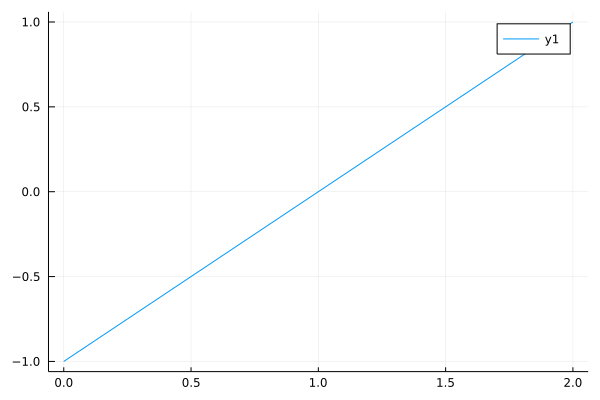

In [138]:
a = 0
b = 2
x = a:0.01:b
xhat = 2*x/(b-a) .- ((a+b)/(b-a))
y = legendre.(xhat, 1)
plot(x,y)

In [139]:
Q = 3
alpha=0.0
beta = 0.0
q = zgj(Q, alpha, beta)
w = wgj(q, alpha, beta)
nm = -ones(Q)
np = ones(Q)

3-element Vector{Float64}:
 1.0
 1.0
 1.0

In [140]:
q1 = (b-a)*q/2 .+ (b+a)/2
w1 = (b-a)*w/2

3-element Vector{Float64}:
 0.5555555555555554
 0.8888888888888888
 0.5555555555555554

In [14]:
xhat = 2*q1/(b-a) .- ((a+b)/(b-a))
leg2 = legendre.(xhat, 1)
leg1 = legendre.(xhat, 4)
ll = leg1 .* leg2
w1' * ll

LoadError: UndefVarError: q1 not defined

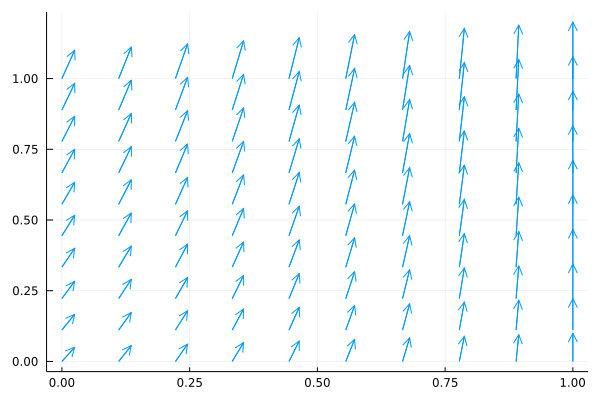

In [65]:
coord_E = [0. 0.;1. 0.;0. 1.;1. 1.]
L = ConstraintMat(coord_E)
VL = GetNullL(L)

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
n = 10
xhat, yhat = meshgrid(LinRange(0,1,n), LinRange(0,1,n))
N = GetACNodalBasis(coord_E, xhat, yhat, VL)
# which N you want to plot
base = 8
u = N[1:n*n,base]
v = N[n*n+1:2*n*n,base]
scale = 0.2
quiver(xhat, yhat, quiver=(scale*u, scale*v))